#Embedding Visualization


##without contrastive learning

pitsA

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch [1/20], Loss: 1.0693
Epoch [2/20], Loss: 0.8475
Epoch [3/20], Loss: 0.7459
Epoch [4/20], Loss: 0.6030
Epoch [5/20], Loss: 0.5128
Epoch [6/20], Loss: 0.4031
Epoch [7/20], Loss: 0.3078
Epoch [8/20], Loss: 0.2446
Epoch [9/20], Loss: 0.1345
Epoch [10/20], Loss: 0.1027
Epoch [11/20], Loss: 0.0703
Epoch [12/20], Loss: 0.0992
Epoch [13/20], Loss: 0.0488
Epoch [14/20], Loss: 0.0486
Epoch [15/20], Loss: 0.0654
Epoch [16/20], Loss: 0.0185
Epoch [17/20], Loss: 0.0116
Epoch [18/20], Loss: 0.0479
Epoch [19/20], Loss: 0.0062
Epoch [20/20], Loss: 0.0034


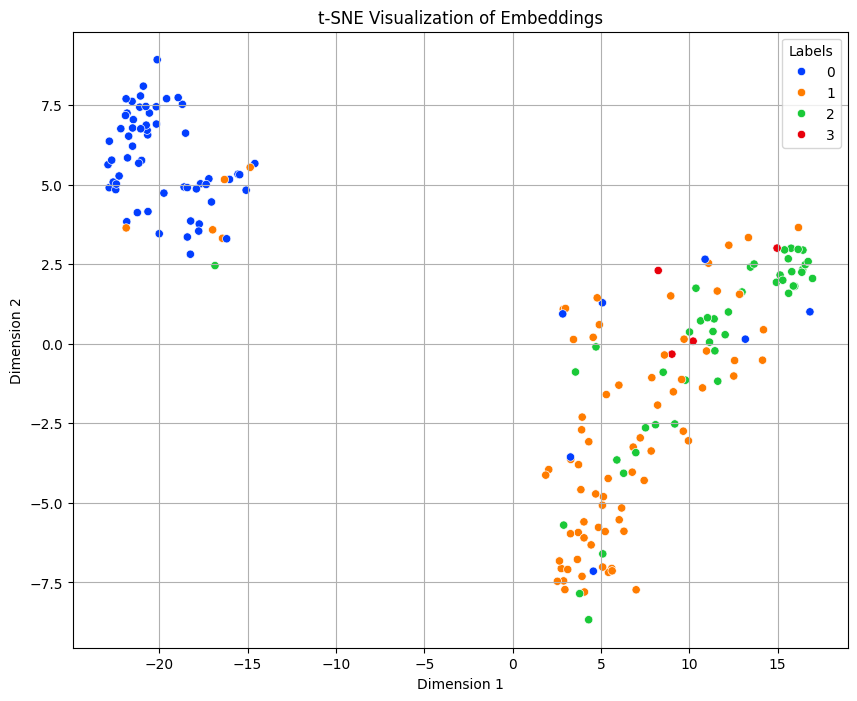

In [ ]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import nltk
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Download NLTK stopwords if not already available
nltk.download('stopwords')

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Load the dataset
file_path = '/content/pitsA.csv'
bug_report_df = pd.read_csv(file_path)

# Preprocess the 'Description' column
bug_report_df['processed_description'] = bug_report_df['Description'].apply(preprocess_text)

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))

# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(descriptions, labels, test_size=0.2)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Custom Dataset class to load bug report data
class BugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad the sequences within the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels = torch.stack(labels)  # Stack labels into a tensor

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

# CNN Classifier Model
class BugReportClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(BugReportClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embedding_dim))  # CNN layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc = nn.Linear(100, num_classes)  # Fully connected layer

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch_size, 1, seq_length, embedding_dim)
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Convolution + Activation + Pooling
        x = torch.mean(x, dim=2)  # Reduce sequence length dimension by averaging
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)  # Final classification layer
        return x

# Create train and test datasets and dataloaders
train_dataset = BugReportDataset(train_descriptions, train_labels, tokenizer)
test_dataset = BugReportDataset(test_descriptions, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Model setup
embedding_dim = 768  # Embedding size of CodeBERT
cnn_model = BugReportClassifier(embedding_dim, num_classes).to(device)

# Include both CNN and CodeBERT in the optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(cnn_model.parameters()),
    lr=2e-5  # Lower learning rate for fine-tuning
)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(20):  # Number of epochs
    cnn_model.train()
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through CodeBERT to get embeddings
        outputs = model(input_ids=inputs, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state

        # Forward pass through CNN classifier
        cnn_outputs = cnn_model(embeddings)

        # Compute loss and backpropagate
        loss = criterion(cnn_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/20], Loss: {running_loss/len(train_loader):.4f}")

# Visualize embeddings
def visualize_embeddings(model, cnn_model, data_loader, num_samples=500):
    model.eval()
    cnn_model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].cpu().numpy()

            # Extract embeddings from CodeBERT
            outputs = model(input_ids=inputs, attention_mask=attention_masks)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token representation

            embeddings.append(cls_embeddings.cpu())
            labels.extend(batch_labels)

            if len(labels) >= num_samples:
                break

    embeddings = torch.cat(embeddings)[:num_samples].numpy()
    labels = labels[:num_samples]

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels, palette='bright')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Labels')
    plt.grid(True)
    plt.show()

visualize_embeddings(model, cnn_model, test_loader)


PitsE

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch [1/20], Loss: 0.9731
Epoch [2/20], Loss: 0.8947
Epoch [3/20], Loss: 0.8328
Epoch [4/20], Loss: 0.7075
Epoch [5/20], Loss: 0.5204
Epoch [6/20], Loss: 0.3796
Epoch [7/20], Loss: 0.2765
Epoch [8/20], Loss: 0.2465
Epoch [9/20], Loss: 0.1195
Epoch [10/20], Loss: 0.1158
Epoch [11/20], Loss: 0.1096
Epoch [12/20], Loss: 0.0707
Epoch [13/20], Loss: 0.0575
Epoch [14/20], Loss: 0.0251
Epoch [15/20], Loss: 0.0123
Epoch [16/20], Loss: 0.0060
Epoch [17/20], Loss: 0.0266
Epoch [18/20], Loss: 0.0435
Epoch [19/20], Loss: 0.0240
Epoch [20/20], Loss: 0.0281


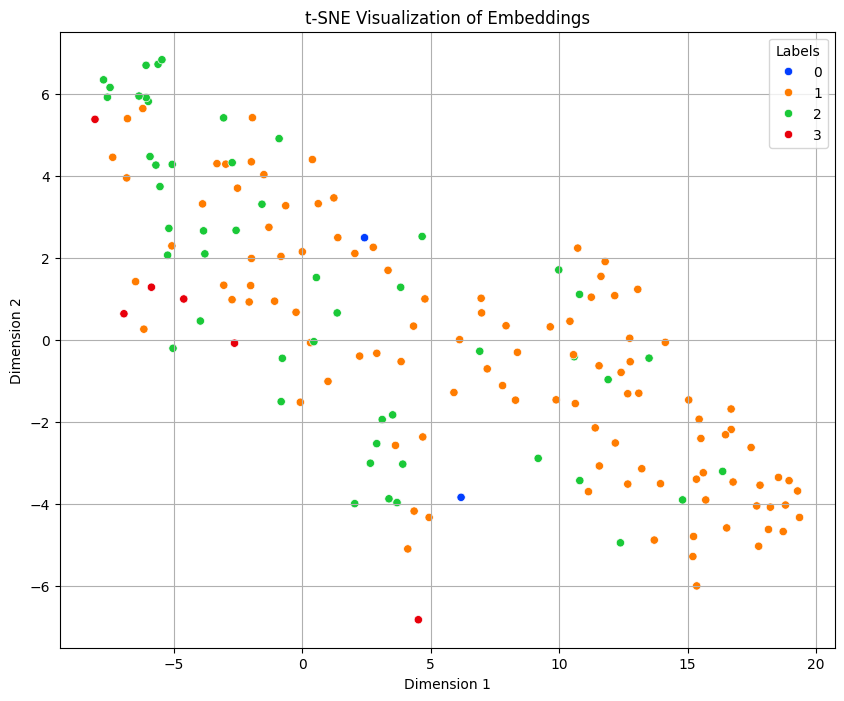

In [1]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import nltk
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Download NLTK stopwords if not already available
nltk.download('stopwords')

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# Load the dataset
file_path = '/content/pitsE.csv'
bug_report_df = pd.read_csv(file_path)

# Preprocess the 'Description' column
bug_report_df['processed_description'] = bug_report_df['Description'].apply(preprocess_text)

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))

# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(descriptions, labels, test_size=0.2)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Custom Dataset class to load bug report data
class BugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad the sequences within the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels = torch.stack(labels)  # Stack labels into a tensor

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

# CNN Classifier Model
class BugReportClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(BugReportClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embedding_dim))  # CNN layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc = nn.Linear(100, num_classes)  # Fully connected layer

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch_size, 1, seq_length, embedding_dim)
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Convolution + Activation + Pooling
        x = torch.mean(x, dim=2)  # Reduce sequence length dimension by averaging
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)  # Final classification layer
        return x

# Create train and test datasets and dataloaders
train_dataset = BugReportDataset(train_descriptions, train_labels, tokenizer)
test_dataset = BugReportDataset(test_descriptions, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Model setup
embedding_dim = 768  # Embedding size of CodeBERT
cnn_model = BugReportClassifier(embedding_dim, num_classes).to(device)

# Include both CNN and CodeBERT in the optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(cnn_model.parameters()),
    lr=2e-5  # Lower learning rate for fine-tuning
)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(20):  # Number of epochs
    cnn_model.train()
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through CodeBERT to get embeddings
        outputs = model(input_ids=inputs, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state

        # Forward pass through CNN classifier
        cnn_outputs = cnn_model(embeddings)

        # Compute loss and backpropagate
        loss = criterion(cnn_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/20], Loss: {running_loss/len(train_loader):.4f}")

# Visualize embeddings
def visualize_embeddings(model, cnn_model, data_loader, num_samples=500):
    model.eval()
    cnn_model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            batch_labels = batch['labels'].cpu().numpy()

            # Extract embeddings from CodeBERT
            outputs = model(input_ids=inputs, attention_mask=attention_masks)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token representation

            embeddings.append(cls_embeddings.cpu())
            labels.extend(batch_labels)

            if len(labels) >= num_samples:
                break

    embeddings = torch.cat(embeddings)[:num_samples].numpy()
    labels = labels[:num_samples]

    # Apply t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    # Plot embeddings
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels, palette='bright')
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Labels')
    plt.grid(True)
    plt.show()

visualize_embeddings(model, cnn_model, test_loader)


##with contrastive learning

pitsA

Classification Epoch [1/20], Loss: 1.0918
Classification Epoch [2/20], Loss: 0.6890
Classification Epoch [3/20], Loss: 0.5549
Classification Epoch [4/20], Loss: 0.4124
Classification Epoch [5/20], Loss: 0.2423
Classification Epoch [6/20], Loss: 0.1095
Classification Epoch [7/20], Loss: 0.1199
Classification Epoch [8/20], Loss: 0.0578
Classification Epoch [9/20], Loss: 0.0290
Classification Epoch [10/20], Loss: 0.0503
Classification Epoch [11/20], Loss: 0.0177
Classification Epoch [12/20], Loss: 0.0121
Classification Epoch [13/20], Loss: 0.0087
Classification Epoch [14/20], Loss: 0.0072
Classification Epoch [15/20], Loss: 0.0057
Classification Epoch [16/20], Loss: 0.0092
Classification Epoch [17/20], Loss: 0.0054
Classification Epoch [18/20], Loss: 0.0072
Classification Epoch [19/20], Loss: 0.0063
Classification Epoch [20/20], Loss: 0.0034


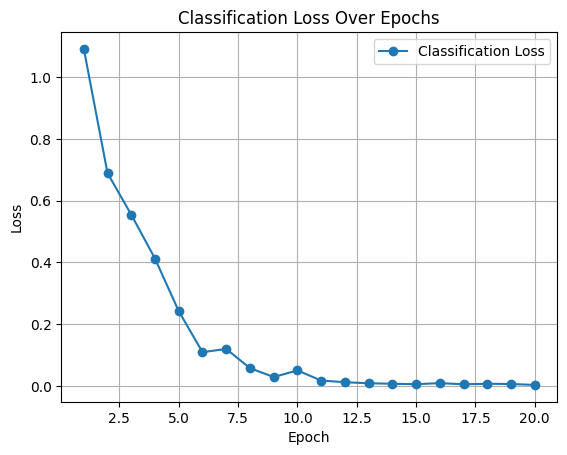

Test Accuracy: 0.7720
Precision: 0.8100
Recall: 0.7720
F1-Score: 0.7682


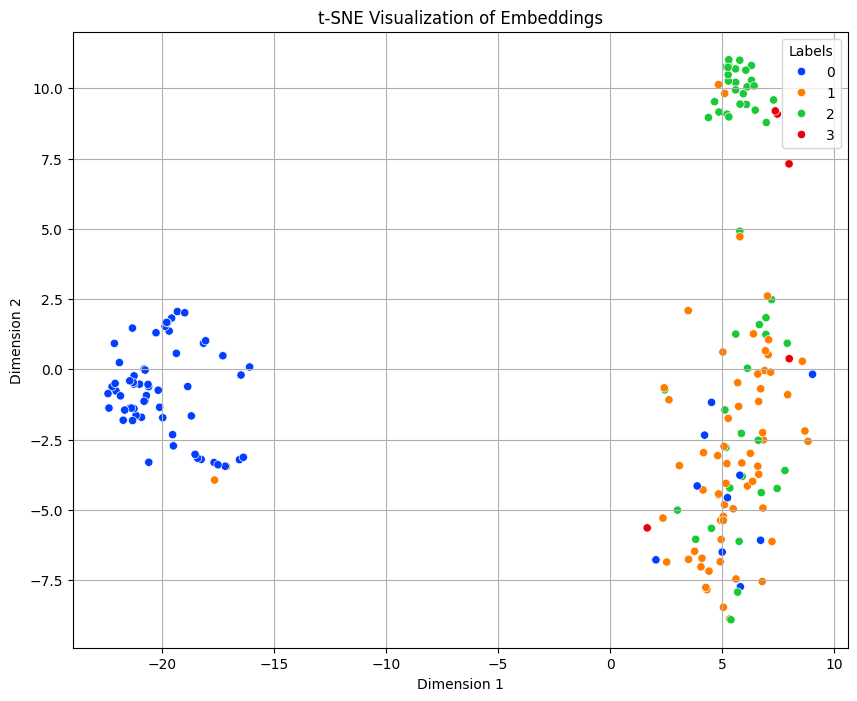

In [5]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE
import seaborn as sns

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Set the seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load the dataset
file_path = '/content/pitsA.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df = bug_report_df.fillna("")

# Preprocess the 'Description' column
bug_report_df['processed_description'] = bug_report_df['Description'].apply(preprocess_text)

# Map original severity labels to new labels
label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
labels = [label_mapping[label] for label in bug_report_df['Severity']]

# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(
    descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Prepare datasets and dataloaders
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classification_model = CodeBERTWithClassifier(model, num_classes=5).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(20):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualize embeddings
def visualize_embeddings(model, data_loader, num_samples=500):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label_batch = batch['label'].cpu().numpy()

            # Extract embeddings from the CLS token
            output = model.codebert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = output.last_hidden_state[:, 0, :]  # CLS token representation

            embeddings.append(cls_embeddings.cpu())
            labels.extend(label_batch)

            if len(labels) >= num_samples:
                break

    embeddings = torch.cat(embeddings)[:num_samples]
    labels = labels[:num_samples]

    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels, palette="bright")
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Labels')
    plt.grid(True)
    plt.show()

visualize_embeddings(classification_model, test_classification_loader)


pitsE

Contrastive Epoch [1/20], Loss: 1.6202
Contrastive Epoch [2/20], Loss: 1.3906
Contrastive Epoch [3/20], Loss: 1.2064
Contrastive Epoch [4/20], Loss: 1.0262
Contrastive Epoch [5/20], Loss: 0.9460
Contrastive Epoch [6/20], Loss: 0.8945
Contrastive Epoch [7/20], Loss: 0.8576
Contrastive Epoch [8/20], Loss: 0.8162
Contrastive Epoch [9/20], Loss: 0.7661
Contrastive Epoch [10/20], Loss: 0.7017
Contrastive Epoch [11/20], Loss: 0.6704
Contrastive Epoch [12/20], Loss: 0.6387
Contrastive Epoch [13/20], Loss: 0.6287
Contrastive Epoch [14/20], Loss: 0.6083
Contrastive Epoch [15/20], Loss: 0.5823
Contrastive Epoch [16/20], Loss: 0.5673
Contrastive Epoch [17/20], Loss: 0.5688
Contrastive Epoch [18/20], Loss: 0.5509
Contrastive Epoch [19/20], Loss: 0.5364
Contrastive Epoch [20/20], Loss: 0.5362


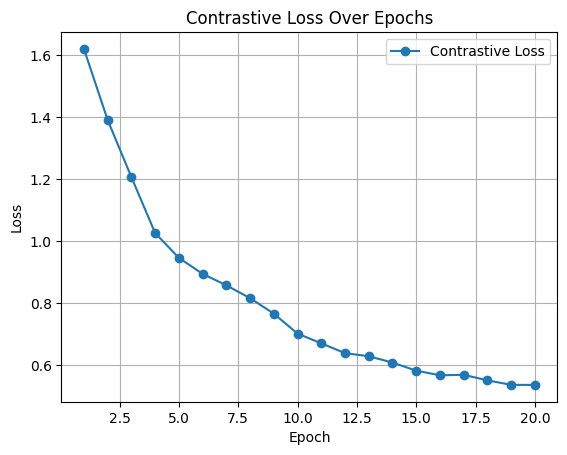

Classification Epoch [1/20], Loss: 0.5845
Classification Epoch [2/20], Loss: 0.2751
Classification Epoch [3/20], Loss: 0.1918
Classification Epoch [4/20], Loss: 0.1309
Classification Epoch [5/20], Loss: 0.1097
Classification Epoch [6/20], Loss: 0.0664
Classification Epoch [7/20], Loss: 0.0917
Classification Epoch [8/20], Loss: 0.0422
Classification Epoch [9/20], Loss: 0.0279
Classification Epoch [10/20], Loss: 0.0231
Classification Epoch [11/20], Loss: 0.0114
Classification Epoch [12/20], Loss: 0.0123
Classification Epoch [13/20], Loss: 0.0040
Classification Epoch [14/20], Loss: 0.0030
Classification Epoch [15/20], Loss: 0.0026
Classification Epoch [16/20], Loss: 0.0021
Classification Epoch [17/20], Loss: 0.0057
Classification Epoch [18/20], Loss: 0.0019
Classification Epoch [19/20], Loss: 0.0016
Classification Epoch [20/20], Loss: 0.0018


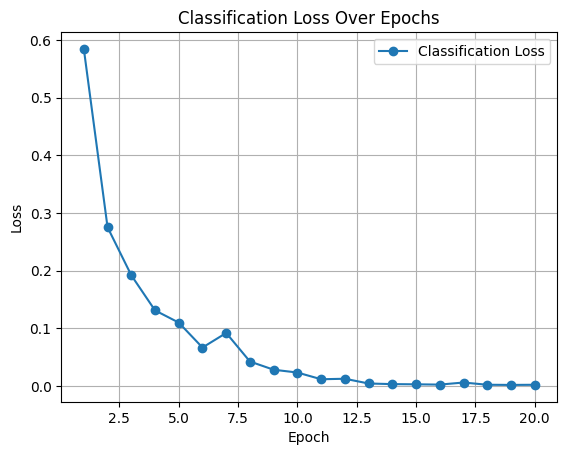

Test Accuracy: 0.7212
Precision: 0.7438
Recall: 0.7212
F1-Score: 0.7249


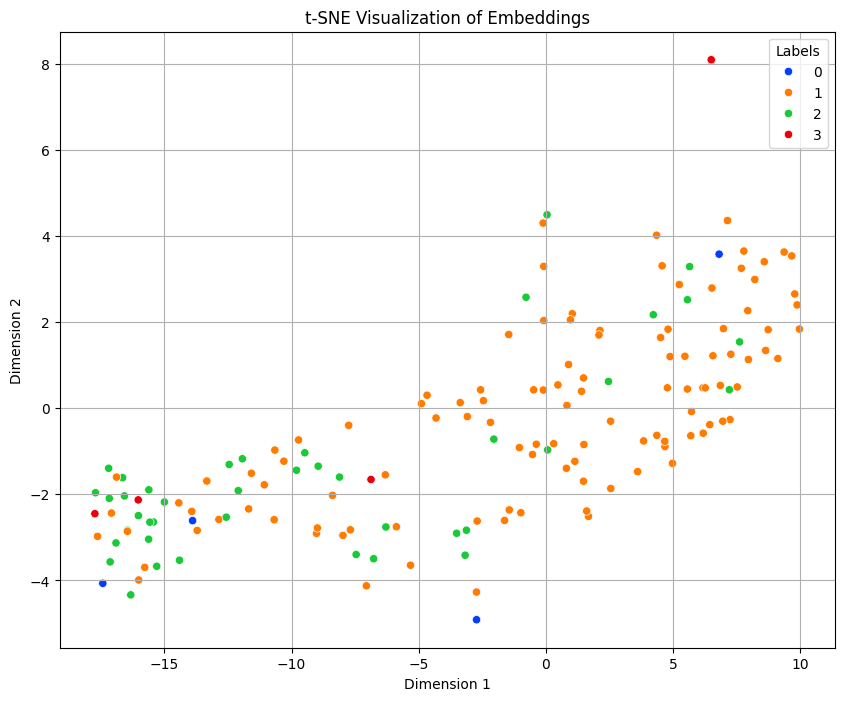

In [8]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import random
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.manifold import TSNE
import seaborn as sns

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Set the seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set the seed
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load the dataset
file_path = '/content/pitsE.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df = bug_report_df.fillna("")

# Preprocess the 'Description' column
bug_report_df['processed_description'] = bug_report_df['Description'].apply(preprocess_text)

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {2: 0, 3: 1, 4: 2, 5: 3}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))

# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append(self.descriptions[idx])

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((group[i], group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((group[i], neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, desc2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad the sequences to the same length
    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'label': labels_tensor
    }

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Fine-tuning CodeBERT with Contrastive Learning
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn, worker_init_fn=seed_worker
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(20):
    model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        outputs_1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).last_hidden_state[:, 0, :]
        outputs_2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(outputs_1, outputs_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

# Classification DataLoaders
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn, worker_init_fn=seed_worker
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn, worker_init_fn=seed_worker
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(20):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Visualize embeddings
def visualize_embeddings(model, data_loader, num_samples=500):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label_batch = batch['label'].cpu().numpy()

            # Extract embeddings from the CLS token
            output = model.codebert(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = output.last_hidden_state[:, 0, :]  # CLS token representation

            embeddings.append(cls_embeddings.cpu())
            labels.extend(label_batch)

            if len(labels) >= num_samples:
                break

    embeddings = torch.cat(embeddings)[:num_samples]
    labels = labels[:num_samples]

    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], hue=labels, palette="bright")
    plt.title('t-SNE Visualization of Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend(title='Labels')
    plt.grid(True)
    plt.show()

visualize_embeddings(classification_model, test_classification_loader)


Contrastive learning

with regularization faster